Motivation by Alexandru: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [78]:
%config InlineBackend.figure_format="retina" #Set png working on notebok
%matplotlib inline

In [79]:
train=pd.read_csv("../Python EDA/train.csv")
test=pd.read_csv("../Python EDA/test.csv")

In [80]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [81]:
all_data=pd.concat((train.loc[:,"MSSubClass":"SaleCondition"],
                   test.loc[:,"MSSubClass":"SaleCondition"]))

In [82]:
all_data.shape

(2919, 79)

# Data Preprocessing
three things here:
1. Transform skewed numeric features by taking log(feature +1)
2. Create Dummy variables for categorical features
3. Replace the numeric missing values (NaN) with the mean of the respective columns

In [83]:
matplotlib.rcParams['figure.figsize']=(12.0,6.0)

In [84]:
prices=pd.DataFrame({"price":train["SalePrice"],"log(Price +1)":np.log1p(train["SalePrice"])})

In [85]:
prices.head()

log(Price +1)   price
0      12.247699  208500
1      12.109016  181500
2      12.317171  223500
3      11.849405  140000
4      12.429220  250000

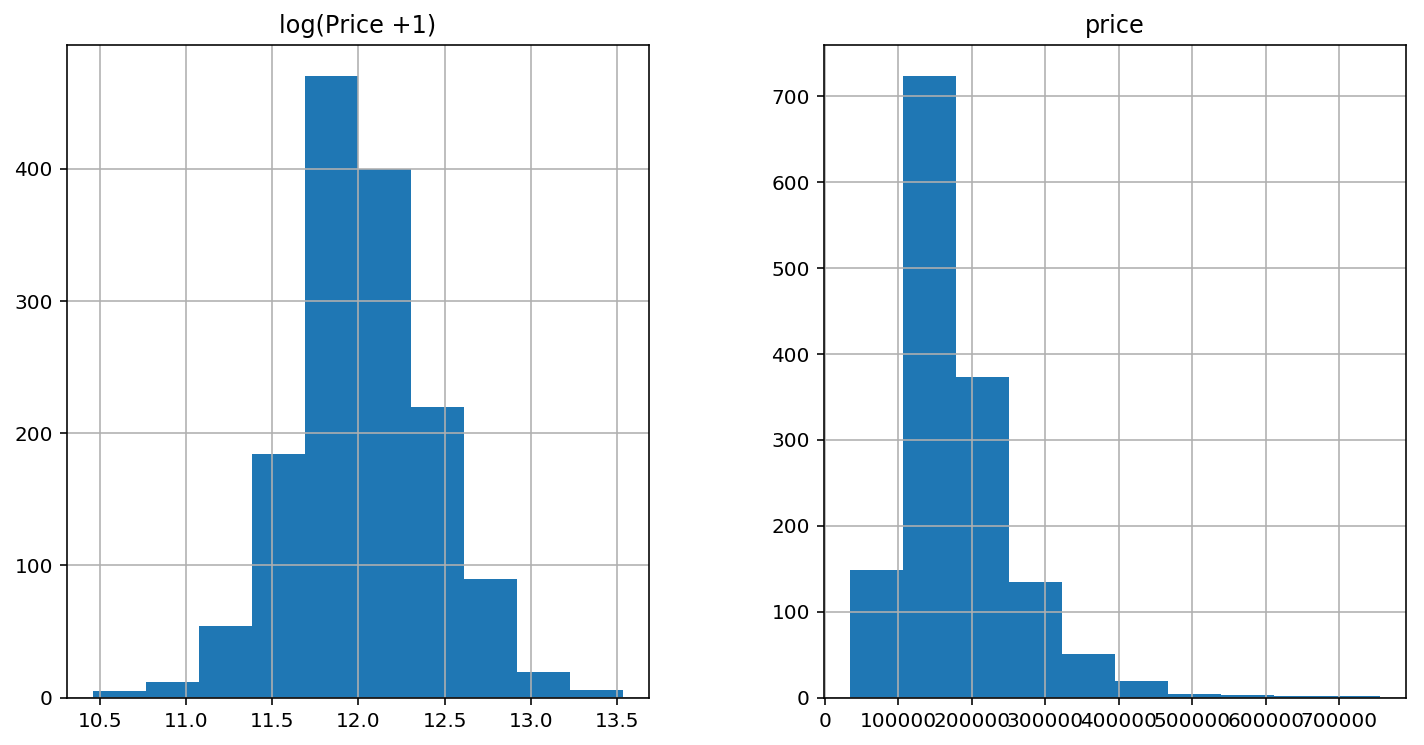

In [86]:
prices.hist();

In [87]:
# Log transform the target
train["SalePrice"]=np.log1p(train["SalePrice"])

#Getting the list of numerical features
numeric_feats=all_data.dtypes[all_data.dtypes != "object"].index



In [88]:
#Combining the lambda function the the applying function to repeatedly apply to a data frame
skewed_feats=train[numeric_feats].apply(lambda x: skew(x.dropna())) #Compute Skewness


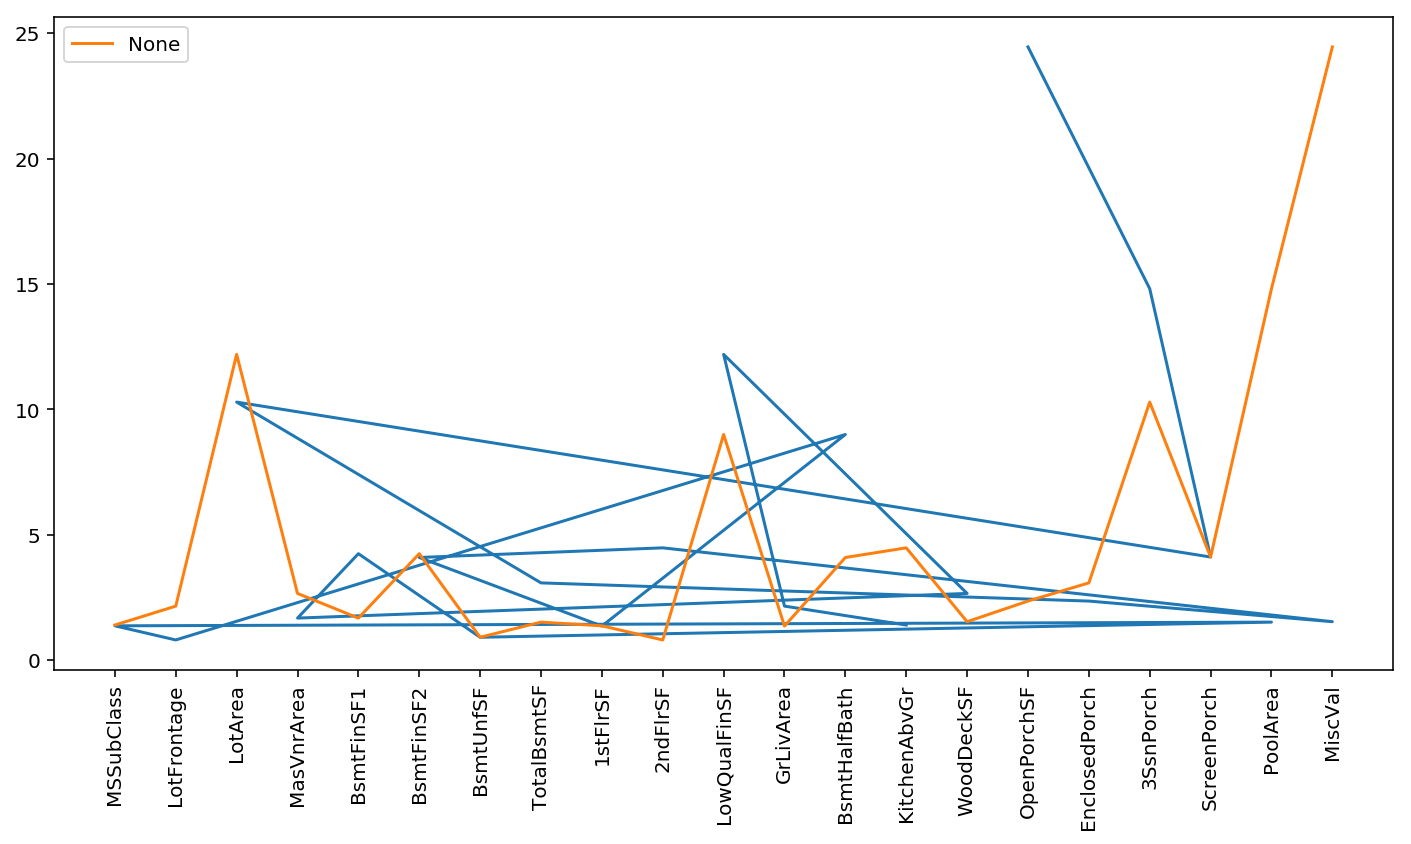

In [89]:
skewed_feats=skewed_feats[skewed_feats >0.75]
plt.plot(skewed_feats); #notice how fucked up this plot is compare to plotting the other way around?
skewed_feats.plot();
plt.xticks(rotation=90)
plt.legend(loc="upper left");

In [90]:
skewed_feats=skewed_feats.index


In [91]:
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [92]:
all_data[skewed_feats]=np.log1p(all_data[skewed_feats])
all_data.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0    4.110874       RL     4.189655  9.042040   Pave   NaN      Reg   
1    3.044522       RL     4.394449  9.169623   Pave   NaN      Reg   
2    4.110874       RL     4.234107  9.328212   Pave   NaN      IR1   
3    4.262680       RL     4.110874  9.164401   Pave   NaN      IR1   
4    4.110874       RL     4.442651  9.565284   Pave   NaN      IR1   

  LandContour Utilities LotConfig      ...       ScreenPorch PoolArea PoolQC  \
0         Lvl    AllPub    Inside      ...               0.0      0.0    NaN   
1         Lvl    AllPub       FR2      ...               0.0      0.0    NaN   
2         Lvl    AllPub    Inside      ...               0.0      0.0    NaN   
3         Lvl    AllPub    Corner      ...               0.0      0.0    NaN   
4         Lvl    AllPub       FR2      ...               0.0      0.0    NaN   

  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0   NaN         NaN     0.0       2    2008        WD         Normal  
1   NaN         NaN     0.0       5    2007        WD         Normal  
2   NaN         NaN     0.0       9    2008        WD         Normal  
3   NaN         NaN     0.0       2    2006        WD        Abnorml  
4   NaN         NaN     0.0      12    2008        WD         Normal  

[5 rows x 79 columns]

In [93]:
#This step is essential if this step isn't performed, SKLEARN would fail
all_data = pd.get_dummies(all_data)

In [94]:
#Filling NAs with the mean of the column: (This missing data processing is not as thorough as the regression studies dude)
all_data=all_data.fillna(all_data.mean())

In [95]:
#Creating matrices for sklearn:
X_train=all_data[:train.shape[0]] #Row level inslicing without defining the columns
X_test=all_data[train.shape[0]:]
y=train.SalePrice

In [96]:
all_data[:train.shape[0]].head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    4.110874     4.189655  9.042040            7            5       2003   
1    3.044522     4.394449  9.169623            6            8       1976   
2    4.110874     4.234107  9.328212            7            5       2001   
3    4.262680     4.110874  9.164401            7            5       1915   
4    4.110874     4.442651  9.565284            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2          ...            \
0          2003    5.283204    6.561031         0.0          ...             
1          1976    0.000000    6.886532         0.0          ...             
2          2002    5.093750    6.188264         0.0          ...             
3          1970    0.000000    5.379897         0.0          ...             
4          2000    5.860786    6.486161         0.0          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 288 columns]

# Models
Now we are going to use regularized linear regression models from the scikit learn module. Both lasso and ridge regularization should be used. 
A function that returns rmse error should be dfined to evaluate the models to evaluate the models and pick the best tuning parameter

In [97]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [98]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible the model is. The higher the regularization the less prone the model will be to overfit. However, this may also lose flexibility and might not capture all the signal in the data

This explains very well why tuninig the alphas is impoart for the lasso/ridge regressions. Alpha is the hyper parameter for lasso + ridge regression

In [99]:
clf=Ridge(alpha=0.05)
clf.fit(X_train,y)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [103]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]


In [104]:
cv_ridge

[0.13893637694024508,
 0.13777538277187865,
 0.13501433618086039,
 0.13136184989399552,
 0.12864892446111867,
 0.12782179689257306,
 0.12733734668670746,
 0.12752940439753818,
 0.12895888148450046,
 0.13099437857191426,
 0.13316366423370268]

Text(0,0.5,'rmse')

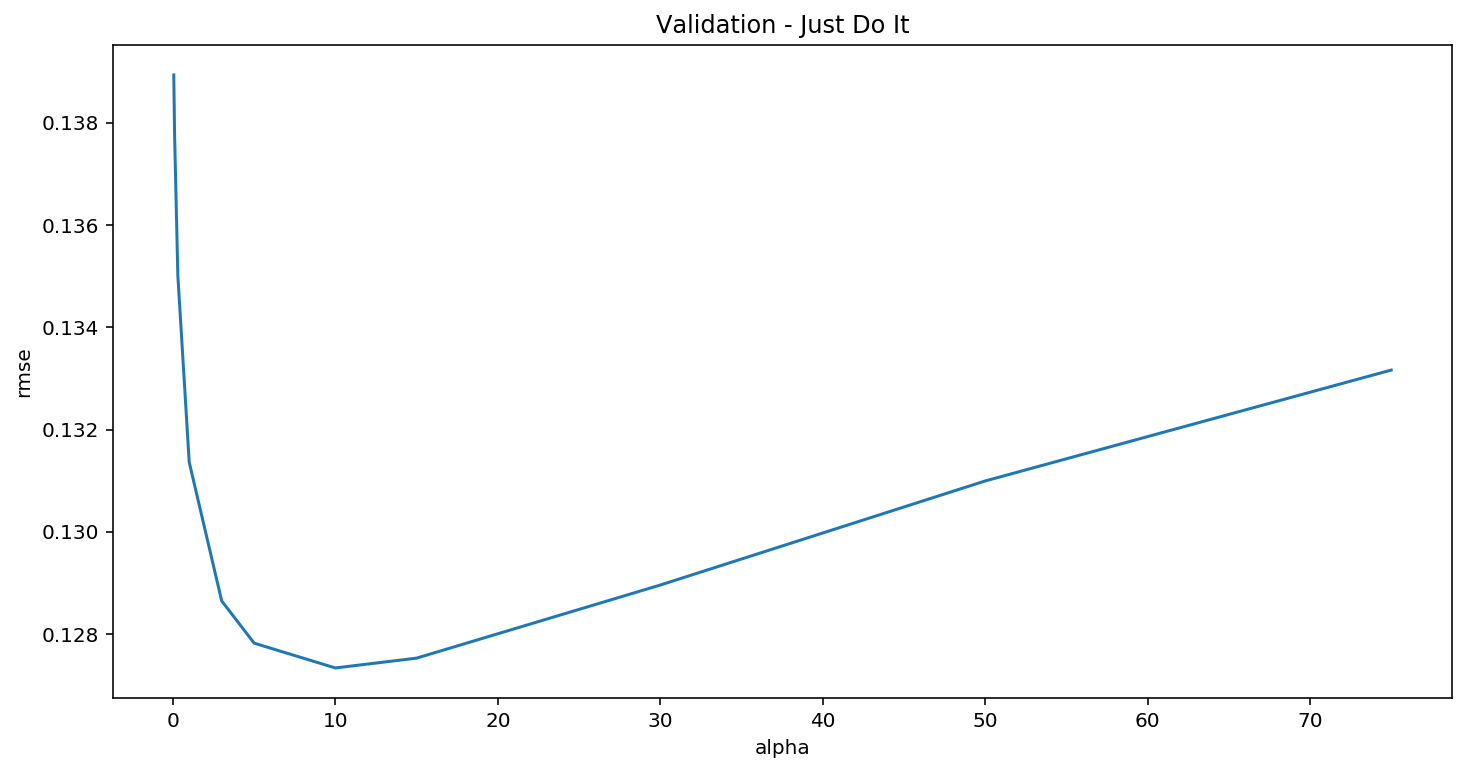

In [105]:
cv_ridge=pd.Series(cv_ridge,index=alphas) #Use the index operator to identify x axis. 
#Alphas by itself is a list
cv_ridge.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [106]:
cv_ridge.min()

0.12733734668670746

For the ridge regression, there's a RMSE about 0.127. Trying out the lasso model. Using the lasso cv to figure out the best alpha. 

In [108]:
model_lasso=LassoCV(alphas=[1,0.1,0.001,0.0005]).fit(X_train,y)

In [109]:
rmse_cv(model_lasso).mean()

0.12314421090977448

Lasso performs better. Now using lasso on the test set. Feature selection is done direclty through lasso

In [110]:
coef=pd.Series(model_lasso.coef_,index=X_train.columns)

In [117]:
print('Lasso Picked ' + str(sum(coef !=0))+" variables and eliminated the other "+\
      str(sum(coef==0))+" variables")

Lasso Picked 111 variables and eliminated the other 177 variables


Although lass selects features automatically but they aren't necessary correct. Especially since there are a lot of collinear features in the dataset. Running lasso a few times on boostrapped samples to see how stable the feature selection is.

Looking directly at the most important coefficients"

In [118]:
imp_coef=pd.concat([coef.sort_values().head(10),
                   coef.sort_values().tail(10)])

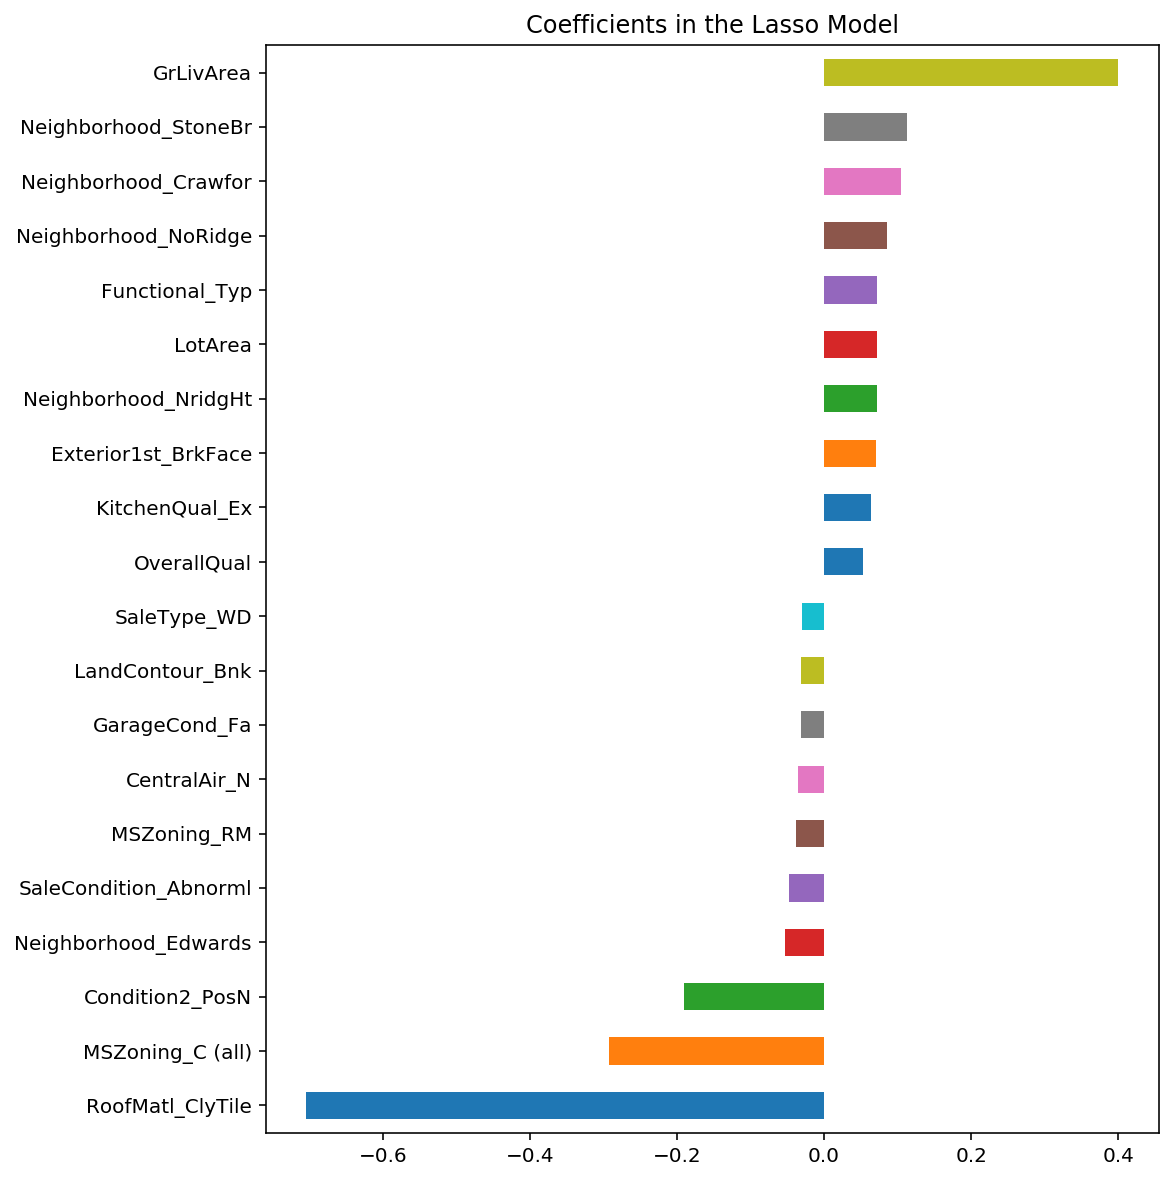

In [121]:
matplotlib.rcParams['figure.figsize']=(8,10)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model");

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

In [123]:
#Let's look at the residuals as well:
matplotlib.rcParams['figure.figsize']=(6.0,6.0)

preds=pd.DataFrame({"preds":model_lasso.predict(X_train),"true":y}) #Calling this to predict

In [126]:
preds.head() #This becomes the predicted value vs the true value

preds       true
0  12.244881  12.247699
1  12.160932  12.109016
2  12.294685  12.317171
3  12.060877  11.849405
4  12.616734  12.429220

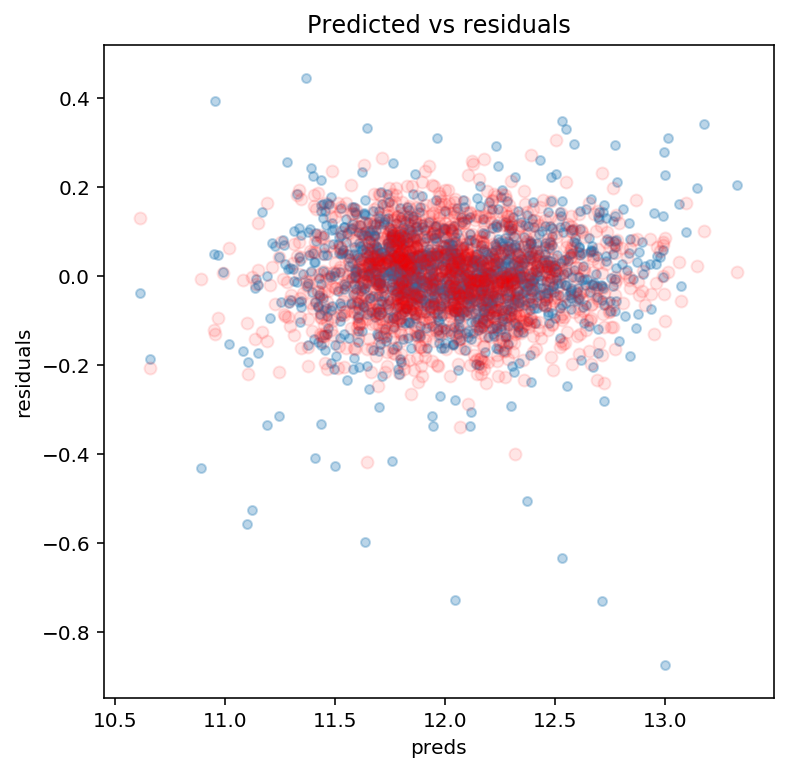

In [144]:
#Adding another column to find the residuals
preds["residuals"]=preds["true"]-preds['preds']
preds.plot(x="preds",y="residuals",kind='scatter',alpha=0.3) #man the scatter is called within the function again
#Notice that in this method, the xy labels don't have to be called directly
plt.title("Predicted vs residuals")

#Adding random points on the same graph
y_random=np.random.normal(0,0.1,len(preds))
plt.scatter(x=preds.preds,y=y_random,alpha=0.1,c="red")
plt.legend(loc="upper left"); #Why does this legend not show up

# XGBoost 

Since I can't install xgboost right as of yet. Skipping this. But when I do, I can come back to this later

https://www.kaggle.com/apapiu/regularized-linear-models

# Trying out Keras 
feedforeward Neural nets

In [147]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#At this moment, just installed Keras, Tensorflow

In [148]:
X_train=StandardScaler().fit_transform(X_train)

In [149]:
#The preprocessing API calls from SKlearn is really good 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [150]:
X_tr.shape

(1095, 288)

In [151]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ..., 
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [155]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  app.launch_new_instance()


In [156]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [158]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/1
1095/1095 [==============================] - 0s 41us/step - loss: 144.2748 - val_loss: 150.5825


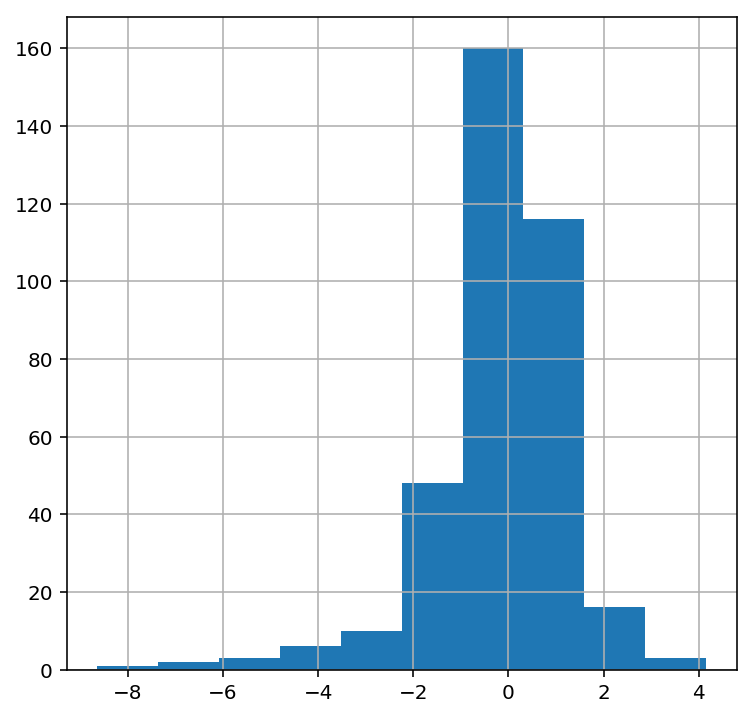

In [161]:
pd.Series(model.predict(X_val)[:,0]).hist();

I have no idea what this is man. What the hell. HOw to interpret or anything. Maybe later once I become fully fluent with all the APIs from Sklearn, keras, tensorflow etc, I'd be okay.